Combined branch

In [319]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pandas as pd
import networkx as nx
import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc
from ndlib.utils import multi_runs
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
from ndlib.viz.mpl.DiffusionPrevalence import DiffusionPrevalence

In [ ]:
rng = np.random.default_rng(seed=42)

Define gillespie's algorithm

In [4]:
def gillespie(initial, beta, gamma, mu, max_time, rng):
    S, I, R = initial

    # initialize
    SIR_states = [[S, I, R]]
    timestamps = [0.0]

    events = np.array([
        [ 1,  0,  0],   # Birth
        [-1, +1,  0],   # Infection
        [ 0, -1, +1],   # Recovery
        [-1,  0,  0],   # Death S
        [ 0, -1,  0],   # Death I
        [ 0,  0, -1]    # Death R
    ])

    while timestamps[-1] < max_time and (S+I+R) > 0:
        N = S + I + R

        event_rates = np.array([
            mu * N,
            beta * S*I/N if N > 0 else 0,
            gamma * I,
            mu * S,
            mu * I,
            mu * R
        ])

        # Draw random uniforms for each event
        U = rng.random(len(event_rates))

        # Compute waiting times (τ_i = -log(U_i)/rate_i)
        dt_list = np.where(event_rates > 0, -np.log(U) / event_rates, np.inf)

        dt_min = np.min(dt_list)
        event = np.argmin(dt_list)

        if dt_min == np.inf:
            break

        # Update time
        timestamps.append(timestamps[-1] + dt_min)

        # Update state
        dS, dI, dR = events[event]
        S, I, R = max(0, S+dS), max(0, I+dI), max(0, R+dR)

        SIR_states.append([S,I,R])

    return np.array(timestamps), np.array(SIR_states)


In [5]:
def SIR_demography(y, t, N, beta, gamma, mu):
    '''SIR model with demography'''
    
    dSdt = mu - beta*y[0]*y[1] - mu*y[0]
    dIdt = beta*y[0]*y[1] - gamma*y[1] - mu*y[1]
    dRdt = gamma*y[1] - mu*y[2]
    
    return [dSdt, dIdt, dRdt]

C:\Users\theyn\AppData\Local\Temp\ipykernel_15476\3606823268.py:33: RuntimeWarning: divide by zero encountered in divide
  dt_list = np.where(event_rates > 0, -np.log(U) / event_rates, np.inf)


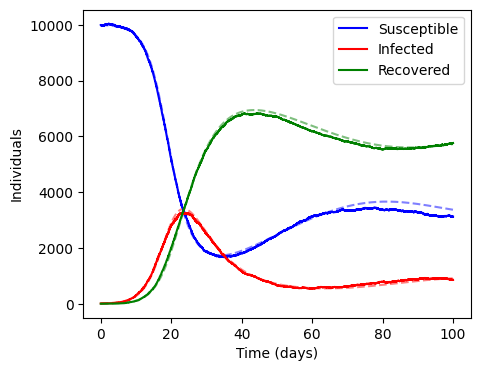

In [12]:
# Define population parameters
N = 10000
I0 = 10

# Define model parameters
beta = 1/2
gamma = 1/7
mu = 0.02

# Duration of simulation
days = 100

# Parameters for gillepsie algorithm
initial = [N-I0, I0, 0]
event_rates = [mu, beta, gamma, mu, mu, mu]

# Run gillepsie algorithm
time, values = gillespie(initial, beta, gamma, mu, 100, rng)

# Gather values over time for each compartment
susceptible = [event[0] for event in values]
infected = [event[1] for event in values]
recovered = [event[2] for event in values]

# Inital parameters deterministic model
y0 = [(N-I0)/N, I0/N, 0]

# Determine timesteps and resolution
t = np.linspace(0, days, 1001)

# Get deteministic solution
solution = odeint(SIR_demography, y0, t, args=(N, beta, gamma, mu))

# Plot data
fig = plt.figure(figsize=(5,4))

# Plot deteministic model
plt.plot(t, solution[:,0] * 10000,'b--', alpha=0.5)
plt.plot(t, solution[:,1] * 10000,'r--', alpha=0.5)
plt.plot(t, solution[:,2] * 10000,'g--', alpha=0.5)

# Plot gillepsie model
plt.plot(time, susceptible, 'b-', label=r'Susceptible')
plt.plot(time, infected, 'r-', label=r'Infected')
plt.plot(time, recovered, 'g-', label=r'Recovered')

plt.ylabel('Individuals')
plt.xlabel('Time (days)')
plt.legend(loc='best')
plt.show()

In [13]:
def gillespie_runs(I0, N, betas, gammas, mu, n_runs, max_time, rng):
    # initialize lists 
    all_S, all_I =  [], []
    initial = [N-I0, I0, 0]
    y0 = [(N-I0)/N, I0/N, 0]
    
    interpolation_grid = np.linspace(0, max_time, 1000)
    results = []

    for gamma in gammas:
        for beta in betas:
            run_S, run_I = [], []

            for _ in range(n_runs):
                t, SIR = gillespie(initial, beta, gamma, mu, max_time, rng)
                S, I, R = SIR.T

                # Interpolate to common time grid
                S_interp = np.interp(interpolation_grid, t, S)
                I_interp = np.interp(interpolation_grid, t, I)

                run_S.append(S_interp)
                run_I.append(I_interp)
    
            # stochastic solutions
            all_S = np.array(run_S)
            all_I = np.array(run_I)

            # deterministic solutions
            solution = odeint(SIR_demography, y0, interpolation_grid, args=(N, beta, gamma, mu))
            S_d, I_d, R = solution.T
            results.append((beta, gamma, all_S, all_I, S_d, I_d))
    
    return results, interpolation_grid
              

In [14]:
def compute_statistics(all_S, all_I):
    all_S, all_I = np.array(all_S), np.array(all_I)
    I_mean = all_I.mean(axis=0)
    S_mean = all_S.mean(axis=0)
    I_var = all_I.var(axis=0)
    cov_value = np.cov(S_mean, I_mean)[0, 1]
    return I_mean, S_mean, I_var, cov_value

## Intuition ##
As $R0$ grows, the negative covariance between $I(t)$ and $S(t)$ shrinks due to different parametrical settings of $\beta$ and $\gamma$,

### stochastic resonance ###


In [15]:
def plot_results(beta, gamma, interpolation_grid, all_S, all_I, S_d, I_d, N, n_runs):
    I_mean, S_mean, I_var, cov_SI = compute_statistics(all_S, all_I)

    plt.figure(figsize=(10, 5))
    for S in all_S:
        plt.plot(interpolation_grid, S, color='black', alpha=0.2)
    for I_run in all_I:
        plt.plot(interpolation_grid, I_run, color='gray', alpha=0.2)

    plt.plot(interpolation_grid, I_mean, color='red', lw=2, label='Mean I(t)')
    plt.fill_between(interpolation_grid,
                     I_mean - np.sqrt(I_var),
                     I_mean + np.sqrt(I_var),
                     color='tab:orange', alpha=0.3, label='±1 Std Dev')
    plt.plot(interpolation_grid, S_mean, color='blue', lw=2, label='Mean S(t)')

    plt.plot(interpolation_grid, S_d * N, 'b--', lw=2, label='S(t) deterministic')
    plt.plot(interpolation_grid, I_d * N, 'r--', lw=2, label='I(t) deterministic')

    plt.xlabel("Time")
    plt.ylabel("Individuals")
    plt.title(f"Stochastic Gillespie (β={beta}, γ={gamma}, runs={n_runs})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    
    print(f"β={beta}, γ={gamma}: Cov(S,I) = {cov_SI:.4f}")


In [16]:
rng = np.random.default_rng(42)
I0 = 10
N = 1000
betas = np.linspace(0.1, 2.0, 10)   # from 0.1 to 2.0 inclusive
gammas = np.linspace(0.1, 0.5, 10)  # from 0.1 to 0.5 inclusive
mu = 1/40
n_runs = 10
max_time = 50

results, interpolation_grid = gillespie_runs(I0, N, betas, gammas, mu, n_runs, max_time, rng)

# for beta, gamma, all_S, all_I, S_d, I_d in results:
#     plot_results(beta, gamma, interpolation_grid, all_S, all_I, S_d, I_d, N, n_runs)


C:\Users\theyn\AppData\Local\Temp\ipykernel_15476\3606823268.py:33: RuntimeWarning: divide by zero encountered in divide
  dt_list = np.where(event_rates > 0, -np.log(U) / event_rates, np.inf)


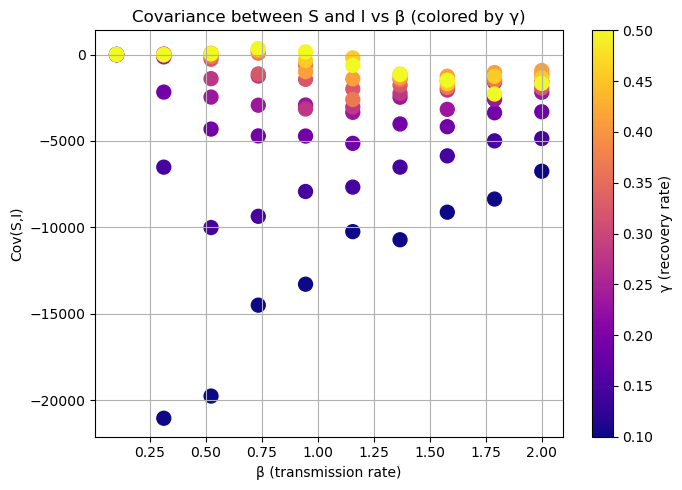

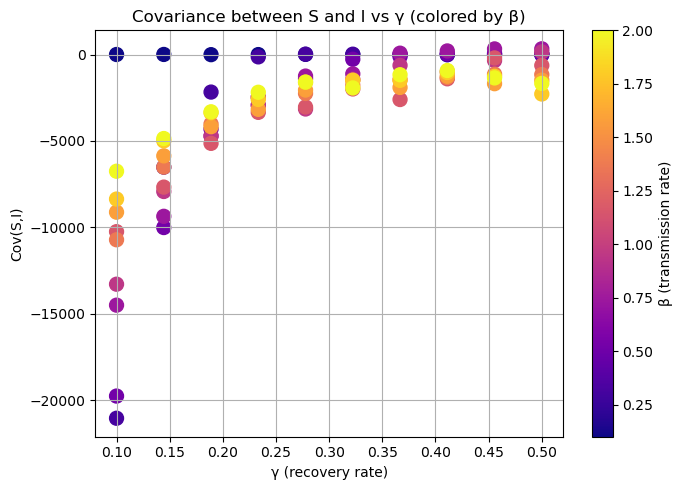

In [ ]:
# make pandas dataframe of the data
cov_data = []
for beta, gamma, all_S, all_I, S_d, I_d in results:
    I_mean, S_mean, I_var, cov_value = compute_statistics(all_S, all_I)
    R0 = beta / gamma
    cov_data.append((beta, gamma, R0, cov_value, I_var))

cov_df = pd.DataFrame(cov_data, columns=["β", "γ", "R₀", "Cov(S,I)", "Var(I)"])
cov_df = cov_df.sort_values(by=["γ", "β"]).reset_index(drop=True)


# Covariance
plt.figure(figsize=(7, 5))
sc = plt.scatter(cov_df["β"], cov_df["Cov(S,I)"],
                 c=cov_df["γ"], cmap="plasma", s=100)
plt.colorbar(sc, label="γ (recovery rate)")
plt.xlabel("β (transmission rate)")
plt.ylabel("Cov(S,I)")
plt.title("Covariance between S and I vs β (colored by γ)")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 5))
sc = plt.scatter(cov_df["γ"], cov_df["Cov(S,I)"],
                 c=cov_df["β"], cmap="plasma", s=100)
plt.colorbar(sc, label="β (transmission rate)")
plt.xlabel("γ (recovery rate)")
plt.ylabel("Cov(S,I)")
plt.title("Covariance between S and I vs γ (colored by β)")
plt.grid(True)
plt.tight_layout()
plt.show()


## Stochastic resonance functions ##
The functions for varying variables among N, mu, beta, gamma

In [ ]:
def stochastic_resonance_N(N_values, I0, beta, gamma, mu, t_max, n_runs, rng):
    interpolation_grid = np.linspace(0, t_max, 1000)
    results = []

    for N_val in N_values:
        initial = [N_val - I0, I0, 0]
        y0 = [(N_val - I0) / N_val, I0 / N_val, 0]

        run_S, run_I = [], []

        for _ in range(n_runs):
            t, SIR = gillespie(initial, beta, gamma, mu, t_max, rng)
            S, I, R = SIR.T
            S_interp = np.interp(interpolation_grid, t, S)
            I_interp = np.interp(interpolation_grid, t, I)
            run_S.append(S_interp)
            run_I.append(I_interp)

        all_S = np.array(run_S)
        all_I = np.array(run_I)

        solution = odeint(SIR_demography, y0, interpolation_grid, args=(N_val, beta, gamma, mu))
        S_d, I_d, R_d = solution.T

        results.append((N_val, all_S, all_I, S_d, I_d))

    return results, interpolation_grid

In [ ]:
def stochastic_resonance_beta(beta_values, I0, N, gamma, mu, t_max, n_runs, rng):
    interpolation_grid = np.linspace(0, t_max, 1000)
    results = []

    for beta_val in beta_values:
        initial = [N - I0, I0, 0]
        y0 = [(N - I0) / N, I0 / N, 0]

        run_S, run_I = [], []

        for _ in range(n_runs):
            t, SIR = gillespie(initial, beta_val, gamma, mu, t_max, rng)
            S, I, R = SIR.T
            S_interp = np.interp(interpolation_grid, t, S)
            I_interp = np.interp(interpolation_grid, t, I)
            run_S.append(S_interp)
            run_I.append(I_interp)

        all_S = np.array(run_S)
        all_I = np.array(run_I)

        solution = odeint(SIR_demography, y0, interpolation_grid, args=(N, beta_val, gamma, mu))
        S_d, I_d, R_d = solution.T

        results.append((beta_val, all_S, all_I, S_d, I_d))

    return results, interpolation_grid

In [ ]:
def stochastic_resonance_gamma(gamma_values, I0, N, beta, mu, t_max, n_runs, rng):
    interpolation_grid = np.linspace(0, t_max, 1000)
    results = []

    for gamma_val in gamma_values:
        initial = [N - I0, I0, 0]
        y0 = [(N - I0) / N, I0 / N, 0]

        run_S, run_I = [], []

        for _ in range(n_runs):
            t, SIR = gillespie(initial, beta, gamma_val, mu, t_max, rng)
            S, I, R = SIR.T
            S_interp = np.interp(interpolation_grid, t, S)
            I_interp = np.interp(interpolation_grid, t, I)
            run_S.append(S_interp)
            run_I.append(I_interp)

        all_S = np.array(run_S)
        all_I = np.array(run_I)

        solution = odeint(SIR_demography, y0, interpolation_grid, args=(N, beta, gamma_val, mu))
        S_d, I_d, R_d = solution.T

        results.append((gamma_val, all_S, all_I, S_d, I_d))

    return results, interpolation_grid

In [ ]:
def stochastic_resonance_mu(mu_values, I0, N, beta, gamma, t_max, n_runs, rng):
    interpolation_grid = np.linspace(0, t_max, 1000)
    results = []

    for mu_val in mu_values:
        initial = [N - I0, I0, 0]
        y0 = [(N - I0) / N, I0 / N, 0]

        run_S, run_I = [], []

        for _ in range(n_runs):
            t, SIR = gillespie(initial, beta, gamma, mu_val, t_max, rng)
            S, I, R = SIR.T
            S_interp = np.interp(interpolation_grid, t, S)
            I_interp = np.interp(interpolation_grid, t, I)
            run_S.append(S_interp)
            run_I.append(I_interp)

        all_S = np.array(run_S)
        all_I = np.array(run_I)

        solution = odeint(SIR_demography, y0, interpolation_grid, args=(N, beta, gamma, mu_val))
        S_d, I_d, R_d = solution.T

        results.append((mu_val, all_S, all_I, S_d, I_d))

    return results, interpolation_grid

In [ ]:
def compute_I_statistics(all_I, interpolation_grid, N_val, beta_val, gamma_val, mu_val):
    """
    Compute mean, std, normalized std, equilibrium, and transient integrals.
    """
    I_mean = all_I.mean(axis=0)
    I_std = all_I.std(axis=0)

    # --- Normalized std (resonance strength) ---
    total_std = np.sqrt(np.mean(I_std**2))
    mean_I_overall = np.mean(I_mean)
    normalized_std = total_std / mean_I_overall if mean_I_overall > 0 else np.nan

    # --- Deterministic equilibrium ---
    R0 = beta_val / (gamma_val + mu_val)
    I_star = mu_val * (R0 - 1) * N_val / beta_val if R0 > 1 else 0

    dt = interpolation_grid[1] - interpolation_grid[0]
    
    transient_integrals_rel = [
        np.trapz(np.abs(I - I_star), dx=dt) /
        ((I_star if I_star > 0 else np.mean(I)) *  N_val)
        for I in all_I
    ]
    mean_transient_rel = np.mean(transient_integrals_rel)

    return I_mean, I_std, normalized_std, I_star, mean_transient_rel

In [ ]:
def plot_stochastic_resonance(results, interpolation_grid, base_N, base_beta, base_gamma, base_mu, vary):
    """
    Plot one figure per parameter value. Show stochastic vs deterministic curves,
    equilibrium line, and annotate σ/mean + transient integrals.
    """
    all_results = []

    for value, all_S, all_I, S_d, I_d in results:
        # --- Assign parameters for this run ---
        if vary == 'N':
            N_val, beta_val, gamma_val, mu_val = value, base_beta, base_gamma, base_mu
        elif vary == 'beta':
            N_val, beta_val, gamma_val, mu_val = base_N, value, base_gamma, base_mu
        elif vary == 'gamma':
            N_val, beta_val, gamma_val, mu_val = base_N, base_beta, value, base_mu
        elif vary == 'mu':
            N_val, beta_val, gamma_val, mu_val = base_N, base_beta, base_gamma, value
        else:
            raise ValueError("Parameter 'vary' must be one of: 'N', 'beta', 'gamma', 'mu'")

        # statistics computed
        I_mean, I_std, normalized_std, I_star, mean_tr_rel = \
            compute_I_statistics(all_I, interpolation_grid, N_val, beta_val, gamma_val, mu_val)

        # plot results
        plt.figure(figsize=(8, 4))
        plt.plot(interpolation_grid, I_mean, 'r', lw=2, label='Mean stochastic I(t)')
        plt.fill_between(interpolation_grid, I_mean - I_std, I_mean + I_std,
                         color='orange', alpha=0.3, label='±1 std')
        plt.plot(interpolation_grid, I_d * N_val, 'b--', lw=2, label='Deterministic I(t)')
        plt.axhline(I_star, color='k', ls='--', lw=1.2, label=f'I* = {I_star:.1f}')
        plt.title(f"Varying {vary} = {value} | N={N_val}, β={beta_val}, γ={gamma_val}, μ={mu_val:.4f}")
        plt.xlabel("Time")
        plt.ylabel("Infected individuals")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

        # Store summary
        all_results.append((value, normalized_std, mean_tr_rel))

    return all_results

/var/folders/py/1fr1xt1s4zg475rpjfmpxbt80000gn/T/ipykernel_4695/2965628816.py:35: RuntimeWarning: divide by zero encountered in divide
  dt_list = np.where(event_rates > 0, -np.log(U) / event_rates, np.inf)
/var/folders/py/1fr1xt1s4zg475rpjfmpxbt80000gn/T/ipykernel_4695/2693918605.py:20: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  np.trapz(np.abs(I - I_star), dx=dt) /


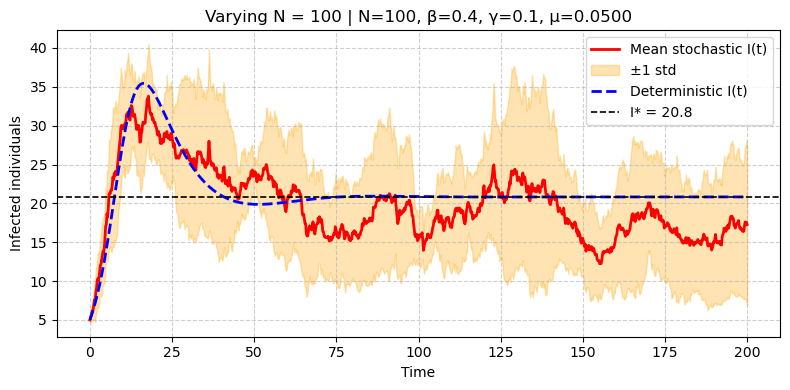

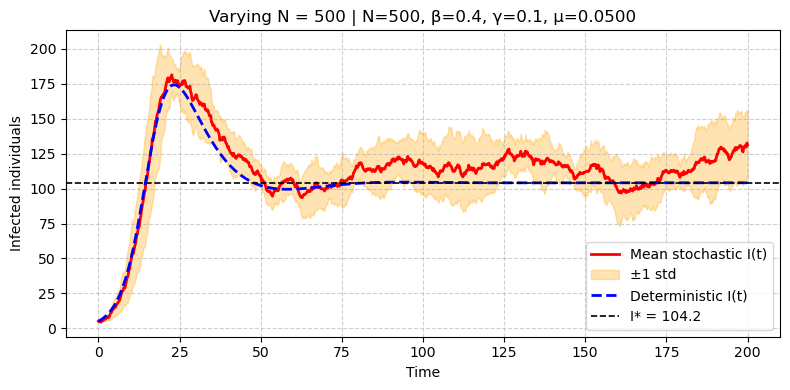

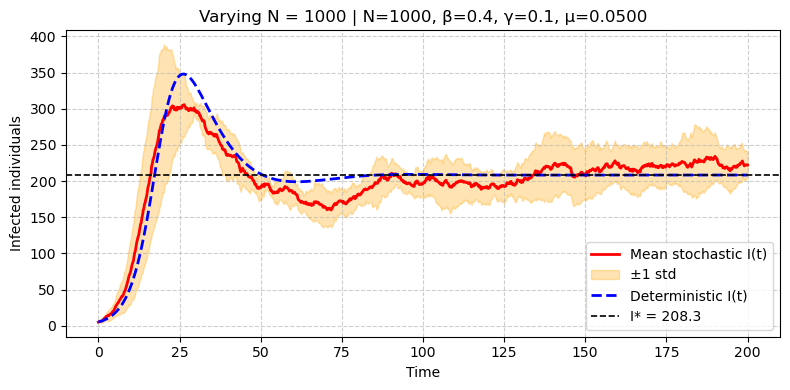

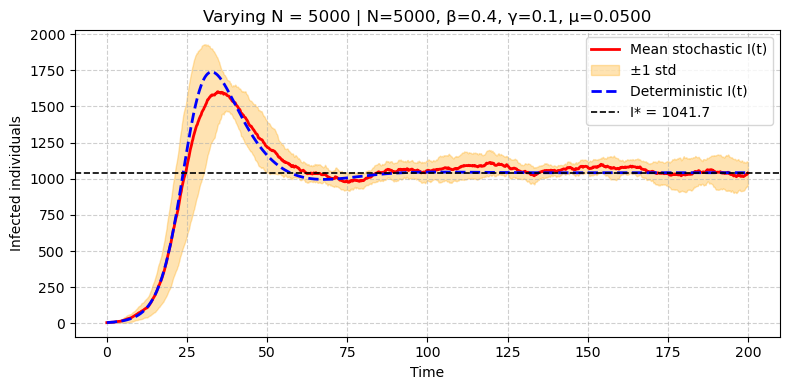

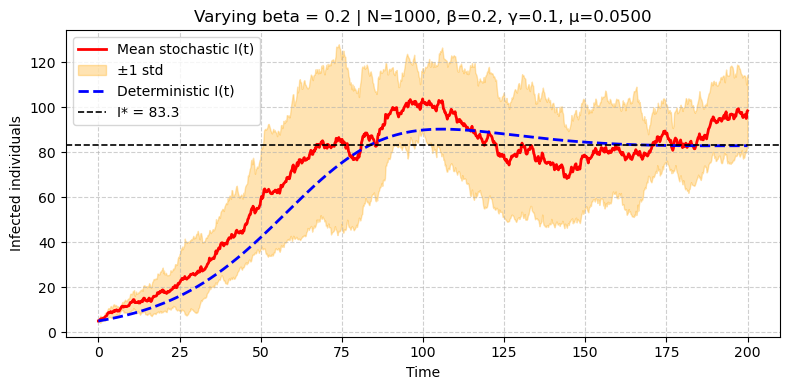

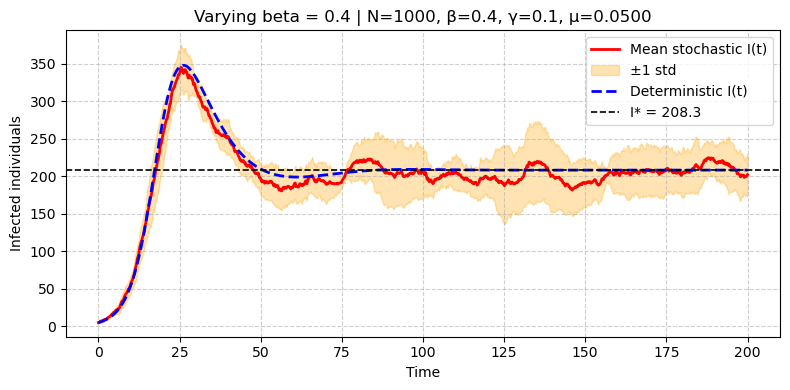

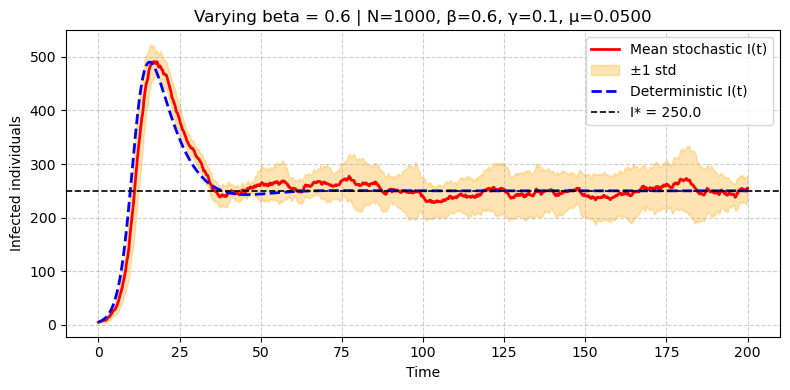

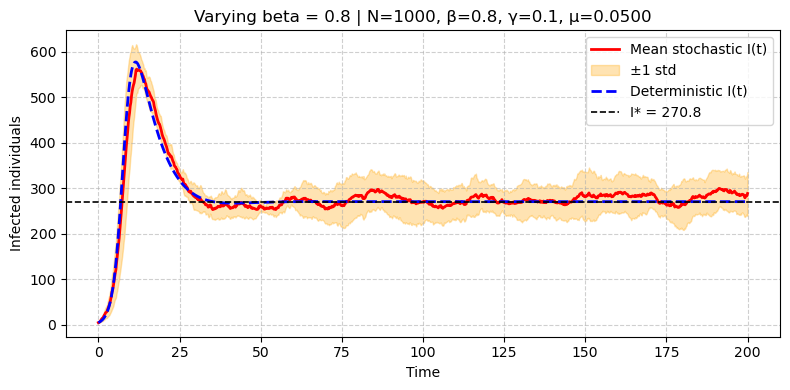

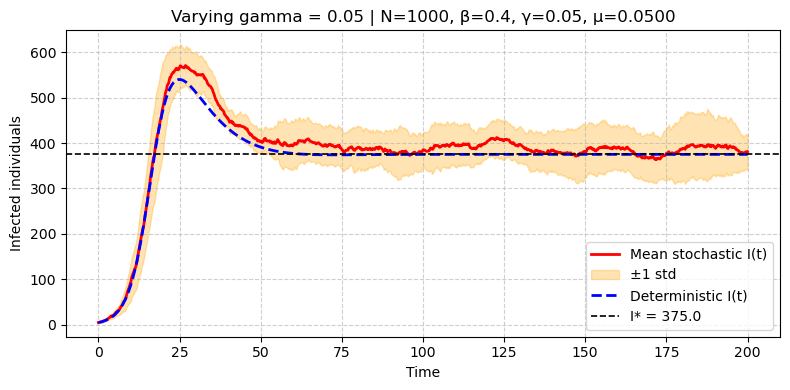

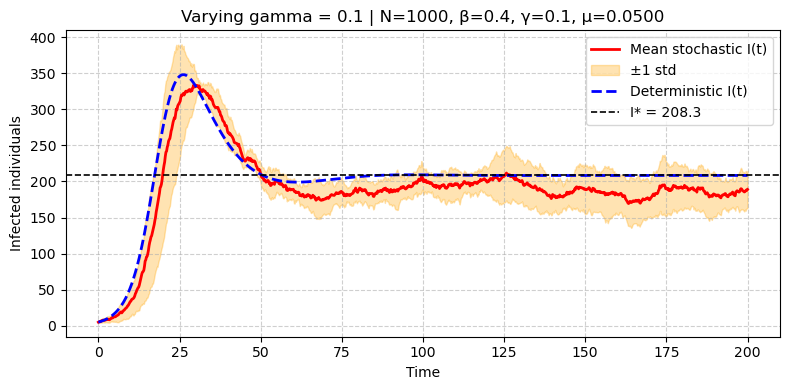

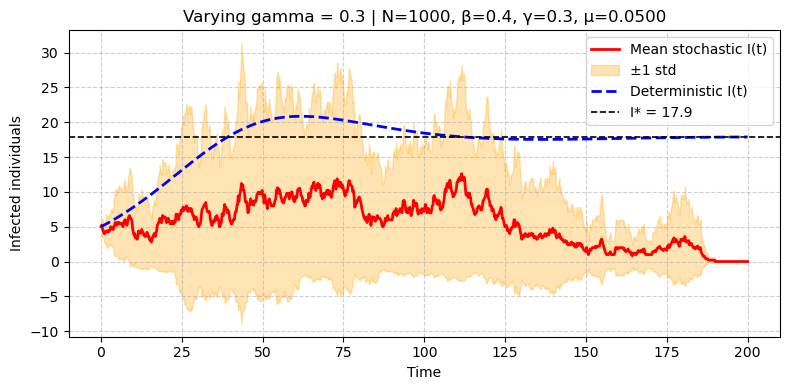

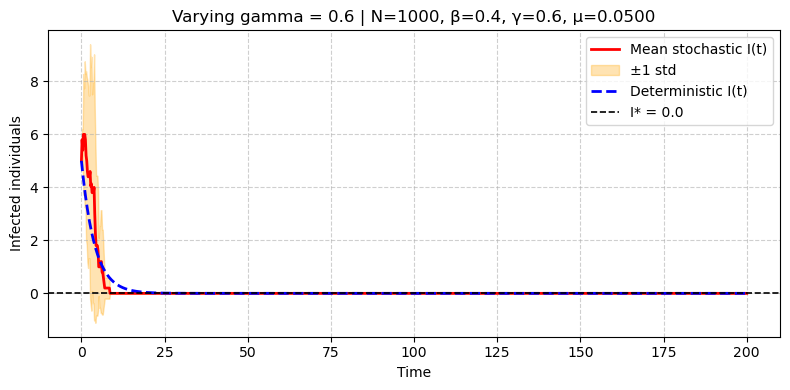

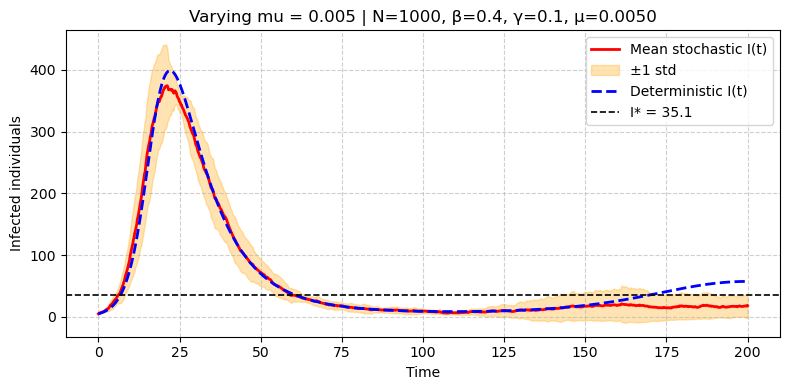

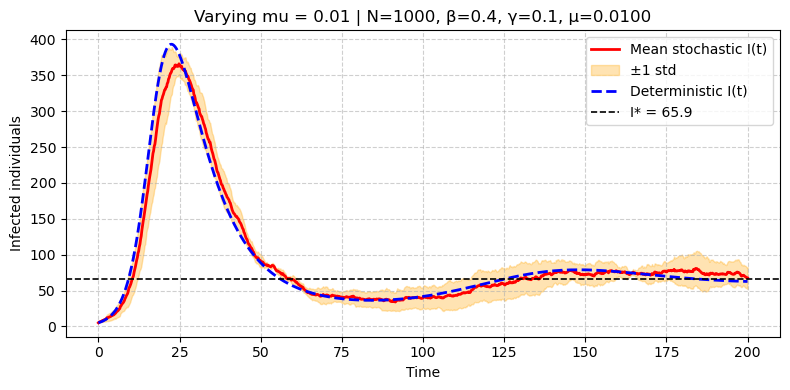

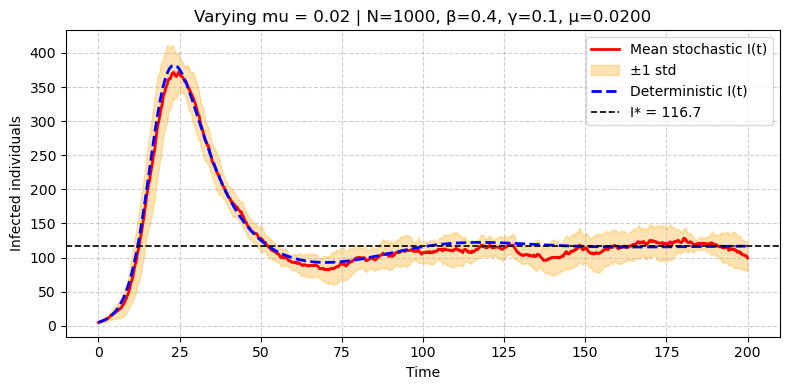

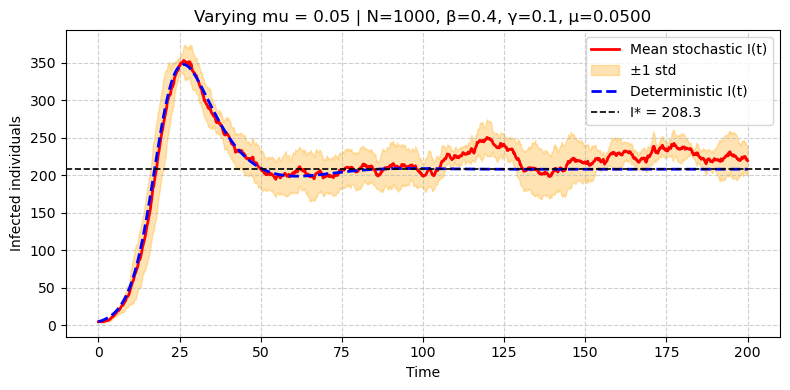

In [ ]:
rng = np.random.default_rng(42)

I0 = 5
N = 1000
beta = 0.4
gamma = 0.1
mu = 0.05
t_max = 200
n_runs = 5

# varying N
N_values = [100, 500, 1000, 5000]
results_N, t_grid = stochastic_resonance_N(N_values, I0, beta, gamma, mu, t_max, n_runs, rng)
N_summary = plot_stochastic_resonance(results_N, t_grid, N, beta, gamma, mu, vary='N')

# varying beta
beta_values = [0.2, 0.4, 0.6, 0.8]
results_beta, t_grid = stochastic_resonance_beta(beta_values, I0, N, gamma, mu, t_max, n_runs, rng)
beta_summary = plot_stochastic_resonance(results_beta, t_grid, N, beta, gamma, mu, vary='beta')

# varying gamma
gamma_values = [0.05, 0.1, 0.3, 0.6]
results_gamma, t_grid = stochastic_resonance_gamma(gamma_values, I0, N, beta, mu, t_max, n_runs, rng)
gamma_summary = plot_stochastic_resonance(results_gamma, t_grid, N, beta, gamma, mu, vary='gamma')

# varying mu
mu_values = [0.005, 0.01, 0.02, 0.05]
results_mu, t_grid = stochastic_resonance_mu(mu_values, I0, N, beta, gamma, t_max, n_runs, rng)
mu_summary = plot_stochastic_resonance(results_mu, t_grid, N, beta, gamma, mu, vary='mu')

In [ ]:
summary_data = {
    "N": N_summary,
    "beta": beta_summary,
    "gamma": gamma_summary,
    "mu": mu_summary
}

rows = []
for param_name, data in summary_data.items():
    for value, std_val, rel_transient in data:
        rows.append({
            "Parameter": param_name,
            "Value": value,
            "Normalized σ/mean": round(std_val, 3),
            "Rel. transient ∫|I−I*|": round(rel_transient, 3)
        })

summary_df = pd.DataFrame(rows)
summary_df = summary_df.sort_values(by=["Parameter", "Value"]).reset_index(drop=True)

print("\n📊 Summary of Stochastic Resonance Results\n")
print(summary_df.to_string(index=False))


📊 Summary of Stochastic Resonance Results

Parameter    Value  Normalized σ/mean  Rel. transient ∫|I−I*|
        N  100.000              0.383                   0.698
        N  500.000              0.163                   0.098
        N 1000.000              0.173                   0.042
        N 5000.000              0.142                   0.008
     beta    0.200              0.320                   0.073
     beta    0.400              0.145                   0.042
     beta    0.600              0.144                   0.042
     beta    0.800              0.144                   0.039
    gamma    0.050              0.130                   0.041
    gamma    0.100              0.163                   0.046
    gamma    0.300              1.649                   0.165
    gamma    0.600              4.659                   0.194
       mu    0.005              0.455                   0.327
       mu    0.010              0.215                   0.148
       mu    0.020        

## Problem 2: Spatial Models - Networks ##

In this question you are asked to develop a set of experiments to design and evaluate
vaccinationstrategiesusinganetworkmodel. UsingthepackageNDLib2 youshouldassess
the spread of a disease (SIR) across different types of model networks (Barabasi Albert,
Watts-Strogatz, Erdos-Reyni). Finally, you will run a simulated vaccination campaign
on a real contact network collected by sociopatterns (link). A modified version of this
dataset can be downloaded from Canvas, the network has been converted to a static
(non-temporal) form and some edges and nodes have been filtered out.

### Relevant graph statistics ###
1. Erdős–Rényi (ER) network: Degree distribution, average path-length and clustering coefficient
2. Barabási–Albert (BA) network: Degree distribution $P(k) = k^{-\gamma}$, highest degrees, average path length
3. Watts–Strogatz (WS) network:


In [ ]:
import networkx as nx
import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc
from ndlib.utils import multi_runs
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
from ndlib.viz.mpl.DiffusionPrevalence import DiffusionPrevalence
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [416]:
def model_configurator(model_type, beta, gamma, infected_initial):
    model = ep.SIRModel(model_type)

    # configuration of model parameters
    config = mc.Configuration()
    config.add_model_parameter('beta', beta)
    config.add_model_parameter('gamma', gamma)
    config.add_model_parameter("fraction_infected", infected_initial)

    # provide initial status 
    model.set_initial_status(config)

    # execution_number = number of runs
    # iteration_number = number of timestamps
    # infection_sets = node list with initial infected nodes
    # nprocesses = cpu parameters
    trends = multi_runs(model, execution_number=10, iteration_number=800, infection_sets=None, nprocesses=4)
    return model, trends

In [467]:

# Parameters
N_values = np.linspace(100, 1000, 10, dtype=int)
k_values = np.linspace(4, 40, 10, dtype=int)

rewiring_prob = 0.5

# Collect rows
rows = []

for N in N_values:
    for k in k_values:

        # model parameters to create equivalent models
        p = k / (N - 1)
        m = max(1, k // 2)

        # Build graphs
        graphs = [
            ("Erdős–Rényi", nx.erdos_renyi_graph(N, p, seed=rng)),
            ("Barabási–Albert", nx.barabasi_albert_graph(N, m, seed=rng)),
            ("Watts–Strogatz", nx.watts_strogatz_graph(N, k, rewiring_prob, seed=rng))
        ]

        # Append all rows
        for name, G in graphs:
            rows.append({
                "model": name,
                "N": N,
                "k": k,
                "edges": G.number_of_edges(),
                "mean_degree": np.mean([d for _, d in G.degree()]),
                "clustering": nx.average_clustering(G),
                "density": nx.density(G)
            })


df = pd.DataFrame(rows)

print(df)


               model     N   k  edges  mean_degree  clustering   density
0        Erdős–Rényi   100   4    186        3.720    0.049697  0.037576
1    Barabási–Albert   100   4    196        3.920    0.135149  0.039596
2     Watts–Strogatz   100   4    200        4.000    0.118548  0.040404
3        Erdős–Rényi   100   8    418        8.360    0.107458  0.084444
4    Barabási–Albert   100   8    384        7.680    0.164107  0.077576
..               ...   ...  ..    ...          ...         ...       ...
295  Barabási–Albert  1000  36  17676       35.352    0.090175  0.035387
296   Watts–Strogatz  1000  36  18000       36.000    0.114354  0.036036
297      Erdős–Rényi  1000  40  19967       39.934    0.039456  0.039974
298  Barabási–Albert  1000  40  19600       39.200    0.092511  0.039239
299   Watts–Strogatz  1000  40  20000       40.000    0.122687  0.040040

[300 rows x 7 columns]


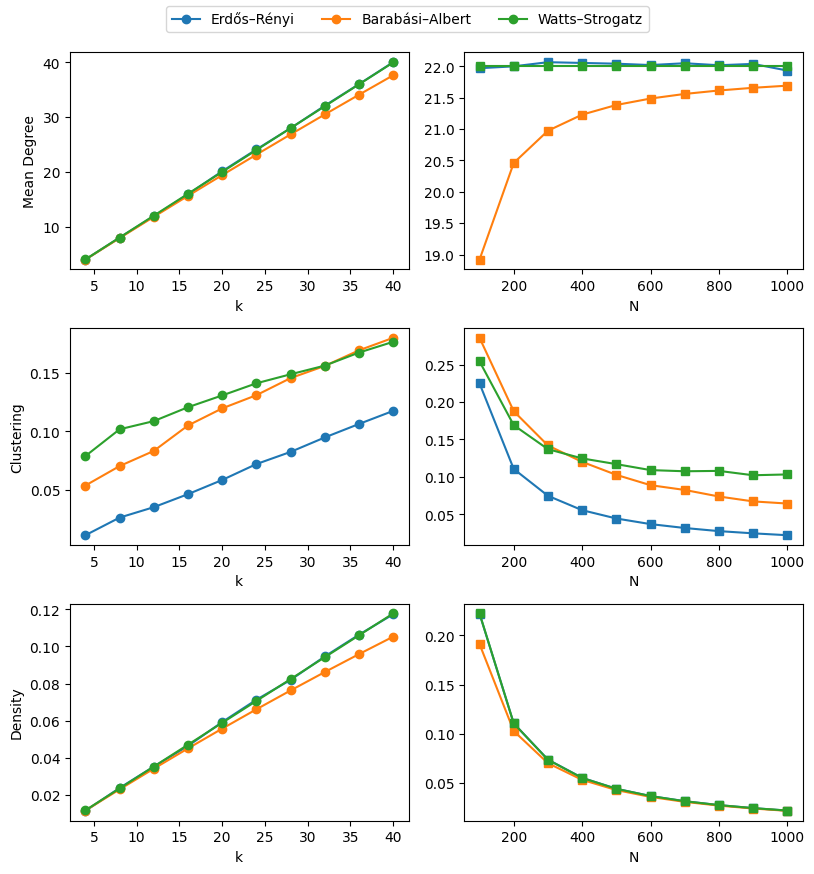

In [472]:
# Unique parameter values
models = df["model"].unique()
N_values = np.unique(df["N"])
k_values = np.unique(df["k"])

# List of statistics to visualize
statistics = ["mean_degree", "clustering", "density"]

fig, axs = plt.subplots(len(statistics), 2, figsize=(8.27, 11.69*0.75))

# Iterate through each statistic
for i, stat in enumerate(statistics):
    
    # axs[i, 0].set_title(f"{stat}")
    # --- 1️⃣ stat vs k (averaged over N)
    for model in models:
        y_vals = [np.mean(df[(df["model"] == model) & (df["k"] == k)][stat]) for k in k_values]
        axs[i, 0].plot(k_values, y_vals, marker='o', label=model)
    axs[i, 0].set_xlabel("k")
    axs[i, 0].set_ylabel(stat.replace("_", " ").title())

    # --- 2️⃣ stat vs N (averaged over k)
    for model in models:
        y_vals = [np.mean(df[(df["model"] == model) & (df["N"] == N)][stat]) for N in N_values]
        axs[i, 1].plot(N_values, y_vals, marker='s', label=model)
    axs[i, 1].set_xlabel("N")

    
fig.legend(["Erdős–Rényi", "Barabási–Albert", "Watts–Strogatz"], ncol=3, loc='upper center')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('compare_networks.png', dpi=300)
plt.show()



In [7]:
def compute_network_statistics(G):
    '''Çompute network statistics for given graph'''
    
    # Degrees
    all_degrees = [d for _, d in G.degree()]
    mean_degree = float(np.mean(all_degrees))
    number_of_edges = G.number_of_edges()
    
    # Average clustering coefficient
    clustering = nx.average_clustering(G)
    
    # # Degree centrality (average)
    # degree_centrality = nx.degree_centrality(G)
    # avg_degree_centrality = float(np.mean(list(degree_centrality.values())))
    
    # Betweenness centrality (average)
    betweenness_centrality = nx.betweenness_centrality(G)
    avg_betweenness_centrality = float(np.mean(list(betweenness_centrality.values())))
    
    # Network density
    density = nx.density(G)
    
    # Return only network-level (average) statistics
    return {
        'mean degree': mean_degree,
        'average clustering coefficient': clustering,
        'average betweenness centrality': avg_betweenness_centrality,
        'network density': density,
        'number of edges': number_of_edges
    }

In [ ]:
n_simulations = 100

# Define disease parameters
# List for all R_0 values
R_0 = np.linspace(1, 5, 9)
gamma = 1/5
# Infection rates are calculated from r_0 and recover rate 
betas = R_0 * gamma
mu = 1/(365*65)

# Duration of simulation
days = 25

# Define population parameters
I0 = 1
population_sizes = [100, 1000, 10000, 100000]

data = []
for N in population_sizes:
    
    # Parameters for gillespie algorithm
    initial = (N-I0, I0, 0)

    extiction_rates = []

    # Run n_simulations for each infection rate (so each value of R_0)
    for beta in betas:
        
        # 
        extinctions = []
        for j in range(n_simulations):
            
            # Run gillespie algorithm
            time, values = gillespie(initial, beta, gamma, mu, days, rng)

            # Check if disease went extinct
            extinct = True if values[-1][1] == 0 else False
            
            # 
            extinctions.append(extinct)
        
        extiction_rates.append(np.mean(extinctions))
        
    data.append(extiction_rates)

C:\Users\theyn\AppData\Local\Temp\ipykernel_15476\3606823268.py:33: RuntimeWarning: divide by zero encountered in divide
  dt_list = np.where(event_rates > 0, -np.log(U) / event_rates, np.inf)


TODO: 
- Pick better collors
- Run 100 simulations per R_0
- Run for 21 values of R_0

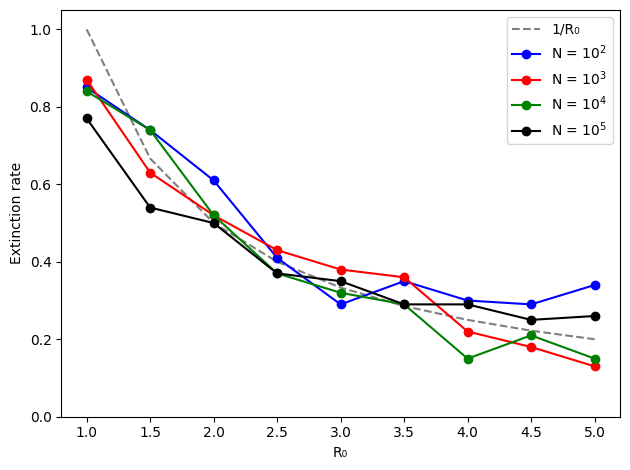

In [478]:
plt.plot(R_0, 1/R_0, 'k--', alpha=0.5)

colors = ['b-o', 'r-o', 'g-o', 'k-o']

# Plot results of the extinction experiment
for i, N in enumerate(data):
    plt.plot(R_0, N, colors[i])
    
    
plt.xlabel(f'R\u2080')
plt.ylabel('Extinction rate')
plt.ylim([0, 1.05])
plt.legend(['1/R\u2080', 'N = $10^2$', 'N = $10^3$', 'N = $10^4$', 'N = $10^5$'], loc='upper right')
plt.tight_layout()
plt.savefig('extinction.png', dpi=300)
plt.show()

NETWORK

In [43]:
# Imports
import networkx as nx
import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc
from ndlib.utils import multi_runs
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
from ndlib.viz.mpl.DiffusionPrevalence import DiffusionPrevalence

In [398]:
def plot_network(G):
    plt.figure(figsize=(7,7))

    degrees = dict(G.degree())
    node_sizes = [v * 10 for v in degrees.values()]  # scale node size by degree

    # Choose a layout
    pos = nx.circular_layout(G)  # k controls spacing between nodes

    # Draw nodes, edges, and labels separately for more control
    nx.draw_networkx_edges(G, pos, alpha=0.8, width=1, edge_color='lightgray')
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='royalblue', alpha=0.95)

    plt.axis('off')
    plt.show()

In [285]:
# Network Definition
G = nx.erdos_renyi_graph(10, 0.4, seed=rng)
plot_network(G)

NameError: name 'plot_network' is not defined

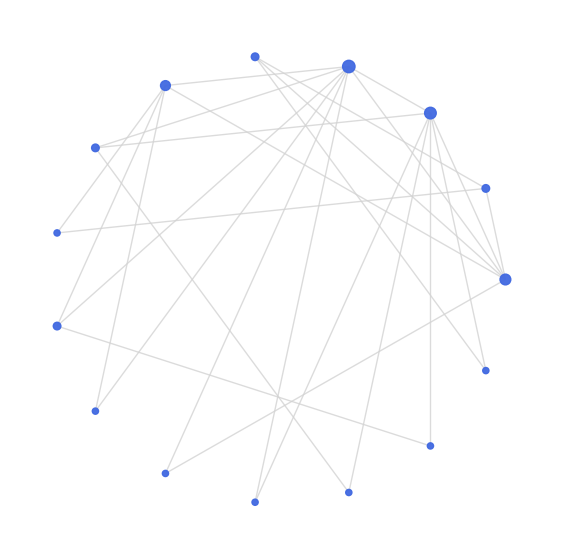

In [407]:
G = nx.barabasi_albert_graph(15, 2, seed=rng)
plot_network(G)

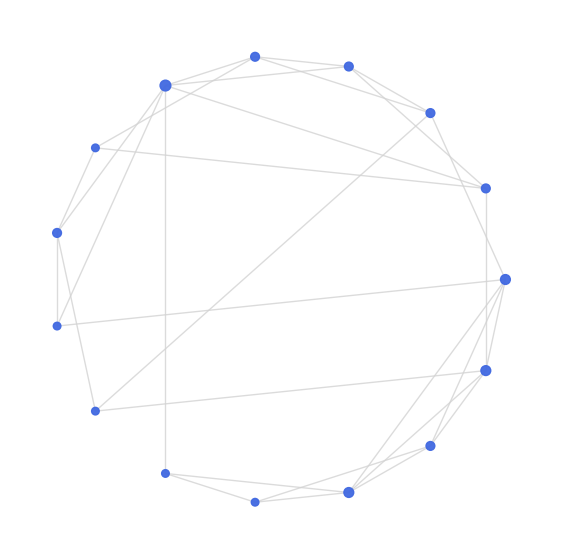

In [406]:
G = nx.watts_strogatz_graph(15, 4, 0.5, seed=rng)
plot_network(G)

In [1]:
import csv
import random

In [286]:
# Import the network
sociopatterns = np.genfromtxt('transmission_network.csv', delimiter=';')[1:,1:]
sociopatterns[sociopatterns!=0] = 1 # Remove weights
G = nx.from_numpy_array(sociopatterns)

In [8]:
print(compute_network_statistics(G))
print(len(G.nodes()))
print(len(G.edges()))

{'mean degree': 6.764705882352941, 'average clustering coefficient': 0.2959852276749502, 'average betweenness centrality': 0.005692021527266808, 'network density': 0.018135940703359093, 'number of edges': 1265}
374
1265


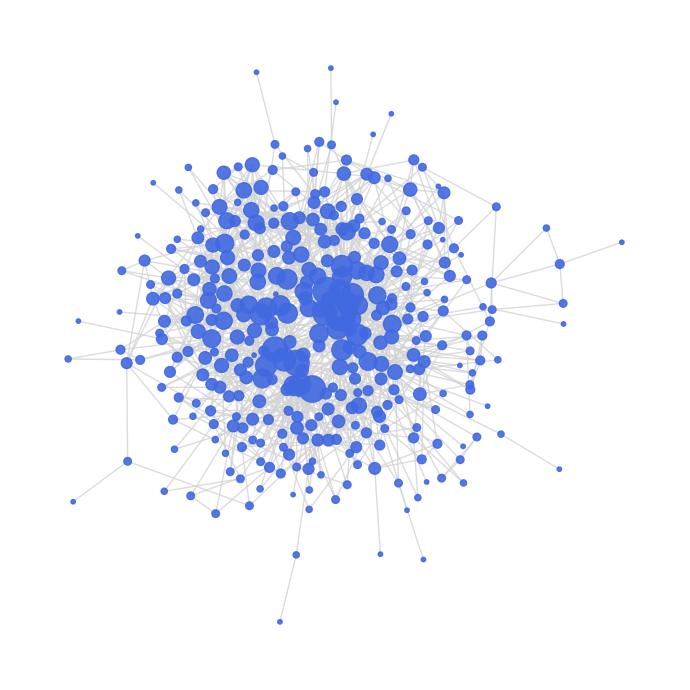

In [113]:
plt.figure(figsize=(7,7))

degrees = dict(G.degree())
node_sizes = [v * 10 for v in degrees.values()]  # scale node size by degree

# Choose a layout
pos = nx.kamada_kawai_layout(G)  # k controls spacing between nodes

# Draw nodes, edges, and labels separately for more control
nx.draw_networkx_edges(G, pos, alpha=0.8, width=1, edge_color='lightgray')
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='royalblue', alpha=0.9)

plt.axis('off')
plt.tight_layout()
plt.savefig('network.png', dpi=300)
plt.show()

In [288]:
def network_vac_rand(G, n_vac, n_test, test_acc, time_steps, rng):
    
    # Gather SIR model
    model = ep.SIRModel(G)
    # Set initial model parameters
    config = mc.Configuration()
    config.add_model_parameter('beta', 0.1)
    config.add_model_parameter('gamma', 1/14)
    config.add_model_parameter("fraction_infected", 5/374)
    model.set_initial_status(config)
        
    vaccinated_nodes = []
    iterations = [model.iteration()]
    
    tested_positive = []

    # Simulate for t timesteps
    for t in range(time_steps):
        
        status = model.status          # current node states
        
        # Gather all nodes that are susceptible
        susceptible_nodes = [n for n, s in status.items() if s == 0]  # 1 = infected in SIR
        
        testable_nodes = [n for n, s in status.items()
                   if n not in vaccinated_nodes and n not in tested_positive]
        
        to_test = testable_nodes[:n_test]
        
        # Infected/removed nodes that are tested susceptible
        false_negatives = [n for n in to_test 
                          if n not in susceptible_nodes and rng.random() > test_acc]
        # Susceptible nodes that are tested infected/removed
        false_positives = [n for n in to_test 
                          if n in susceptible_nodes and rng.random() > test_acc]
        
        # Append all nodes that tested positive (infected/removed)
        tested_positive.extend([n for n in to_test 
                                if (n not in susceptible_nodes or n in false_positives) and n not in false_negatives])
        
        # gather nodes that tested negative (susceptible)
        tested_negative = [n for n in to_test 
                                if (n in susceptible_nodes or n in false_negatives) and n not in false_positives]
        
        # Vaccinate nodes tested susceptible first, if vacs left vaccinate nodes that were not tested
        to_vaccinate = [*tested_negative, *testable_nodes[n_test:]][:n_vac]
                
        # Store vaccinated nodes   
        vaccinated_nodes.extend(to_vaccinate)

        # Vaccinate (mark as "removed" or new state)
        for n in to_vaccinate:
            if model.status[n] == 0:
                model.status[n] = 2  # 2 = recovered/immune   
                
        # Append data of this iteration  
        iteration = model.iteration()  # advance one step
        iterations.append(iteration) 
        
    return iterations

In [289]:
time_steps = 50
n_test = 10
n_vacs = [1, 3, 5, 10]
test_accs = [0.5, 0.75, 1.0]
n_sims = 100

per_accs_rand = []
for test_acc in test_accs:
    per_vacs_rand = []
    for n_vac in n_vacs: 
        # Loop for amount of simulations per condition
        sims = []
        for sim in range(n_sims):
            sims.append(network_vac_rand(G, n_vac, n_test, test_acc, time_steps, rng))  
            
        per_vacs_rand.append(sims)
    per_accs_rand.append(per_vacs_rand)
        

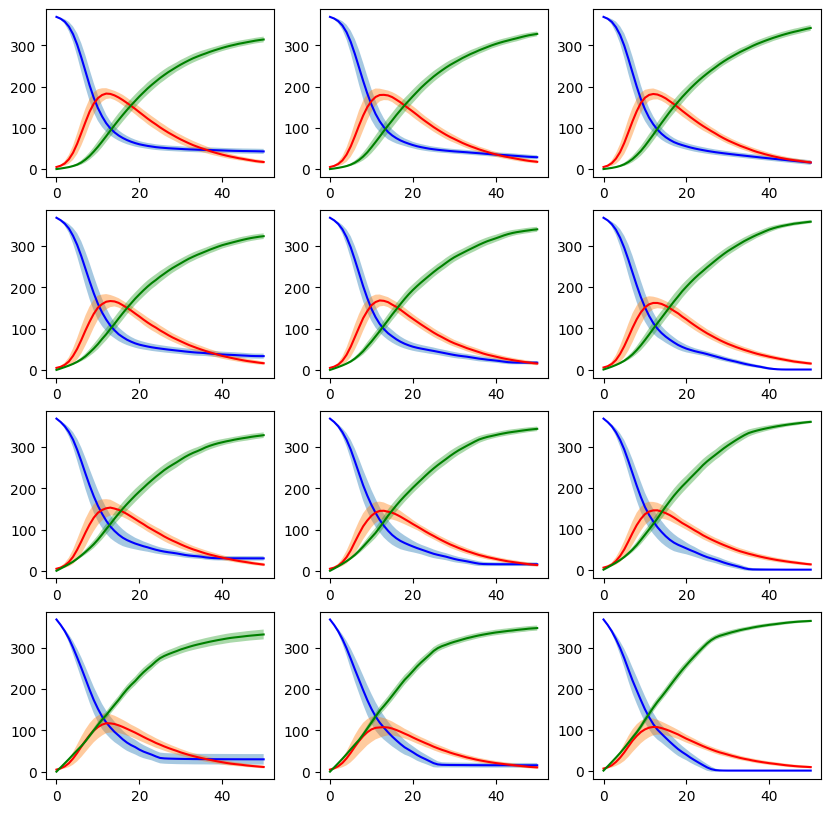

In [290]:
fig, axs = plt.subplots(len(n_vacs), len(test_accs), figsize=(10,10))
t = np.arange(0, time_steps+1)

random_stats = []
for j, per_vacs_rand in enumerate(per_accs_rand):
    stats_per_vacs = []
    for i, sims in enumerate(per_vacs_rand):
        all_S, all_I, all_R = [], [], []
        for sim in sims:
            S, I, R = [], [], []
            for iteration in sim:
                node_count = iteration['node_count']
                S.append(node_count.get(0, 0))
                I.append(node_count.get(1, 0))
                R.append(node_count.get(2, 0))
                
            all_S.append(S)
            all_I.append(I)
            all_R.append(R)
            
        mean_S, std_S = np.array(all_S).mean(axis=0), np.array(all_S).std(axis=0) 
        mean_I, std_I = np.array(all_I).mean(axis=0), np.array(all_I).std(axis=0)      
        mean_R, std_R = np.array(all_R).mean(axis=0), np.array(all_R).std(axis=0)     
        
        stats_per_vacs.append([mean_I, std_I])

        axs[i,j].plot(t, mean_S, 'b-')
        axs[i,j].fill_between(t, mean_S+std_S, mean_S-std_S, alpha=0.4)
        axs[i,j].plot(t, mean_I, 'r-')
        axs[i,j].fill_between(t, mean_I+std_I, mean_I-std_I, alpha=0.4)
        axs[i,j].plot(t, mean_R, 'g-')
        axs[i,j].fill_between(t, mean_R+std_R, mean_R-std_R, alpha=0.4)
    
    random_stats.append(stats_per_vacs)

In [291]:
def network_vac_target(G, n_vac, n_test, test_acc, time_steps, rng):
    
    # Gather SIR model
    model = ep.SIRModel(G)
    # Set initial model parameters
    config = mc.Configuration()
    config.add_model_parameter('beta', 0.1)
    config.add_model_parameter('gamma', 1/14)
    config.add_model_parameter("fraction_infected", 5/374)
    model.set_initial_status(config)
        
    tested_positive = []
    vaccinated_nodes = []
    iterations = [model.iteration()]

    # Simulate for t timesteps
    for t in range(time_steps):
        
        status = model.status          # current node states
        
        # Gather all nodes that are susceptible
        susceptible_nodes = [n for n, s in status.items() if s == 0]  # 1 = infected in SIR
        
        # Pick 10 random nodes from whole network
        random_nodes = random.sample(list(status.keys()), 10)
        
        # gather all neighbors of random nodes
        neighbors = []
        for n in random_nodes:
            for neighbor in G.neighbors(n):
                neighbors.append(neighbor)
                
        # Sort unique elements by counts
        unique, counts = np.unique(neighbors, return_counts=True)
        sorted_indices = np.argsort(-counts)
        sorted_neighbors = unique[sorted_indices].tolist()
        
        # Gather nodes that have not been tested positive, have not bee vaccinated and are not in sorted_neighbors
        non_neighbors = [n for n, s in status.items() 
                          if n not in sorted_neighbors]
        random.shuffle(non_neighbors)
        
        # First test sorted_neighbors, if tests left -> test random nodes not tested positive/not vaccinated
        priority_nodes = [n for n in sorted_neighbors + non_neighbors
                            if n not in vaccinated_nodes and n not in tested_positive]
        
        to_test = priority_nodes[:n_test]
        
        # Infected/removed nodes that are tested susceptible
        false_negatives = [n for n in to_test 
                          if n not in susceptible_nodes and rng.random() > test_acc]
        # Susceptible nodes that are tested infected/removed
        false_positives = [n for n in to_test 
                          if n in susceptible_nodes and rng.random() > test_acc]
        
        # Append all nodes that tested positive (infected/removed)
        tested_positive.extend([n for n in to_test 
                                if (n not in susceptible_nodes or n in false_positives) and n not in false_negatives])
        
        # gather nodes that tested negative (susceptible)
        tested_negative = [n for n in to_test 
                                if (n in susceptible_nodes or n in false_negatives) and n not in false_positives]
        
        # Vaccinate nodes tested susceptible first, if vacs left vaccinate nodes that were not tested
        to_vaccinate = [*tested_negative, *priority_nodes[n_test:]][:n_vac]
                
        # Store vaccinated nodes   
        vaccinated_nodes.extend(to_vaccinate)

        # Vaccinate (mark as "removed" or new state)
        for n in to_vaccinate:
            if model.status[n] == 0:
                model.status[n] = 2  # 2 = recovered/immune   
                
        # Append data of this iteration  
        iteration = model.iteration()  # advance one step
        iterations.append(iteration) 
        
    return iterations
        

In [292]:
time_steps = 50
n_test = 10
n_vacs = [1, 3, 5, 10]
test_accs = [0.5, 0.75, 1.0]
n_sims = 100

# Loop for different testing accuracies
per_accs = []
for test_acc in test_accs:
    # Loop for different number of vaccinations
    per_vacs = []
    for n_vac in n_vacs: 
        # Loop for amount of simulations per condition
        sims = []
        for sim in range(n_sims):
            sims.append(network_vac_target(G, n_vac, n_test, test_acc, time_steps, rng))  
            
        per_vacs.append(sims)
        
    per_accs.append(per_vacs)


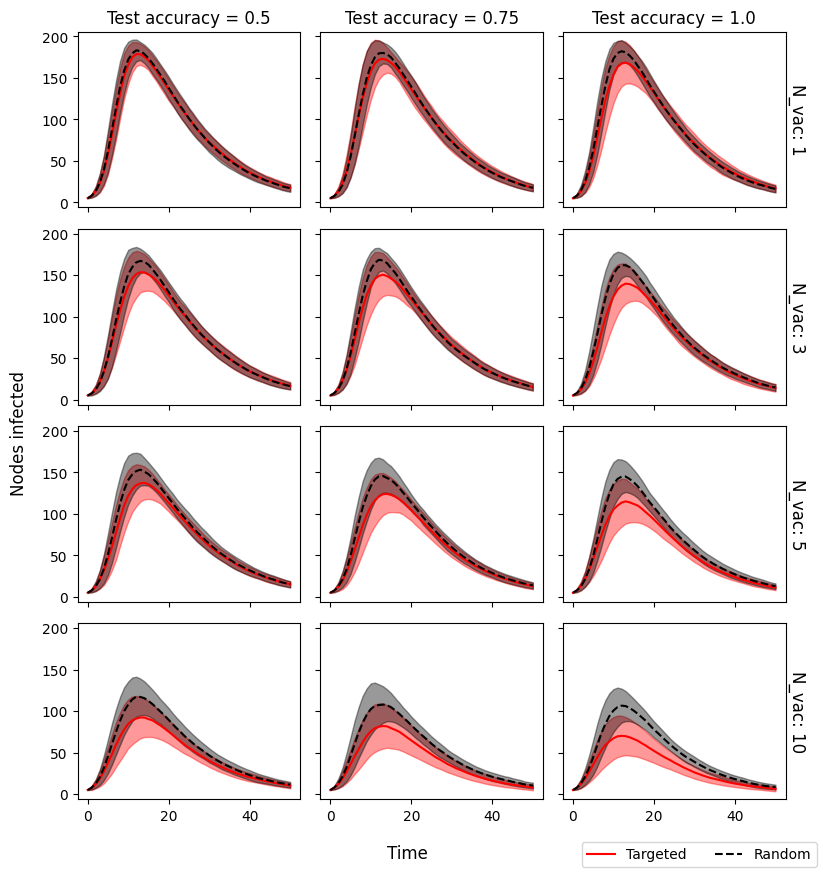

In [293]:
fig, axs = plt.subplots(len(n_vacs), len(test_accs), figsize=(8.27, 11.69*0.75), sharex=True, sharey=True)
t = np.arange(0, time_steps+1)

for j, per_vacs in enumerate(per_accs):
    for i, sims in enumerate(per_vacs):
        all_S, all_I, all_R = [], [], []
        for sim in sims:
            S, I, R = [], [], []
            for iteration in sim:
                node_count = iteration['node_count']
                S.append(node_count.get(0, 0))
                I.append(node_count.get(1, 0))
                R.append(node_count.get(2, 0))
                
            all_S.append(S)
            all_I.append(I)
            all_R.append(R)
            
        mean_S, std_S = np.array(all_S).mean(axis=0), np.array(all_S).std(axis=0) 
        mean_I, std_I = np.array(all_I).mean(axis=0), np.array(all_I).std(axis=0)      
        mean_R, std_R = np.array(all_R).mean(axis=0), np.array(all_R).std(axis=0)     

        # Plot results of targeted vaccination
        # axs[i,j].plot(t, mean_S, 'b-')
        # axs[i,j].fill_between(t, mean_S+std_S, mean_S-std_S, alpha=0.4)
        tar = axs[i,j].plot(t, mean_I, 'r-')
        axs[i,j].fill_between(t, mean_I+std_I, mean_I-std_I, color='r', alpha=0.4)
        # axs[i,j].plot(t, mean_R, 'g-')
        # axs[i,j].fill_between(t, mean_R+std_R, mean_R-std_R, alpha=0.4)
        
        # Plot results of random vaccination
        mean_I_rand, std_I_rand = random_stats[j][i]
        rand = axs[i,j].plot(t, mean_I_rand, 'k--')
        axs[i,j].fill_between(t, mean_I_rand+std_I_rand, mean_I_rand-std_I_rand, color='k', alpha=0.4)
        
        # Set the titles of the first row of subplots 
        if i == 0:
            axs[i,j].set_title(f'Test accuracy = {test_accs[j]}')     
        
# Create the y-labels on the right side of the far most right subplots
for i, n_vac in enumerate(n_vacs):
    # Rotate the y-labels -90 degrees
    axs[i, 2].set_ylabel(f'N_vac: {n_vac}', fontsize = 12, rotation = -90)
    # Set the coordinates of the y-labels
    axs[i, 2].yaxis.set_label_coords(1.01, 0.5)

        
fig.supxlabel('Time')
fig.supylabel('Nodes infected')
fig.legend([tar[0], rand[0]], ['Targeted', 'Random'], loc='lower right', ncol=2)


plt.tight_layout()
plt.savefig('vac_campaign.png', dpi=300)
plt.show()

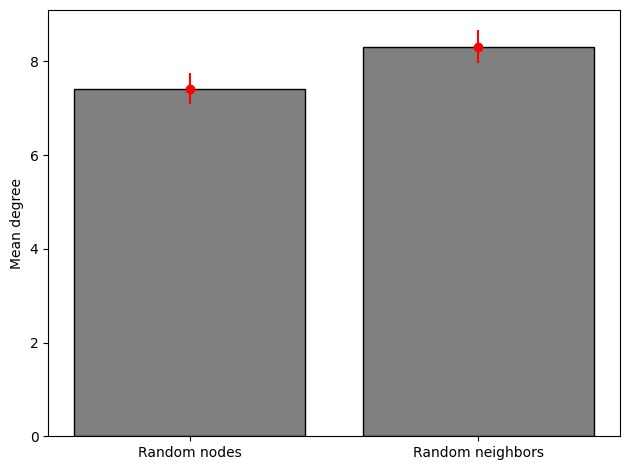

In [273]:
rand_stats = []
neigh_stats = []

for i in range(1000):
    random_nodes = random.sample(range(len(G.nodes())), k=50)
    random_degrees = G.degree(random_nodes)
    mean_rand_degrees = np.mean([d for n, d in random_degrees])

    rand_stats.append(mean_rand_degrees)

    neighbor_nodes = []
    for n in random_nodes:
        neighbors = []
        for neighbor in G.neighbors(n):
            neighbors.append(neighbor)
        
        if len(neighbors) > 0:
            neighbor_nodes.append(random.choice(neighbors))
            
    neighbor_degrees = G.degree(neighbor_nodes)
    mean_neigh_degrees = np.mean([d for n, d in neighbor_degrees])
    neigh_stats.append(mean_neigh_degrees)
    
mean_neigh, std_neigh = np.mean(neigh_stats), np.std(neigh_stats)
mean_rand, std_rand = np.mean(rand_stats), np.std(rand_stats)



plt.bar(['Random nodes', 'Random neighbors'], [mean_rand, mean_neigh], color='gray', edgecolor='k')
plt.errorbar(['Random nodes', 'Random neighbors'], [mean_rand, mean_neigh], yerr=[std_rand, std_neigh], fmt='o', color='r')
plt.ylabel('Mean degree')
plt.tight_layout()
plt.show()

In [276]:
def network_sir(G, beta, gamma, time_steps, rng):
    
    # Gather SIR model
    model = ep.SIRModel(G)
    # Set initial model parameters
    config = mc.Configuration()
    config.add_model_parameter('beta', beta)
    config.add_model_parameter('gamma', gamma)
    config.add_model_parameter("fraction_infected ", 0.05)
    model.set_initial_status(config)
        
    iterations = []
    # Simulate for t timesteps
    for t in range(time_steps):
        
        # Append data of this iteration  
        iteration = model.iteration()  # advance one step
        iterations.append(iteration) 
        
    return iterations
        

In [304]:
def make_graph(name, N, k, rewiring_prob, rng):
    
    p = k / (N - 1)
    m = max(1, k // 2)
    
    match name:
        case "ER":
            G = nx.erdos_renyi_graph(N, p, seed=rng)
            
        case "BA":
            G = nx.barabasi_albert_graph(N, m, seed=rng)
            
        case "WS":
            G = nx.watts_strogatz_graph(N, k, rewiring_prob, seed=rng)
            
        case _:
            G = None
            
    return G

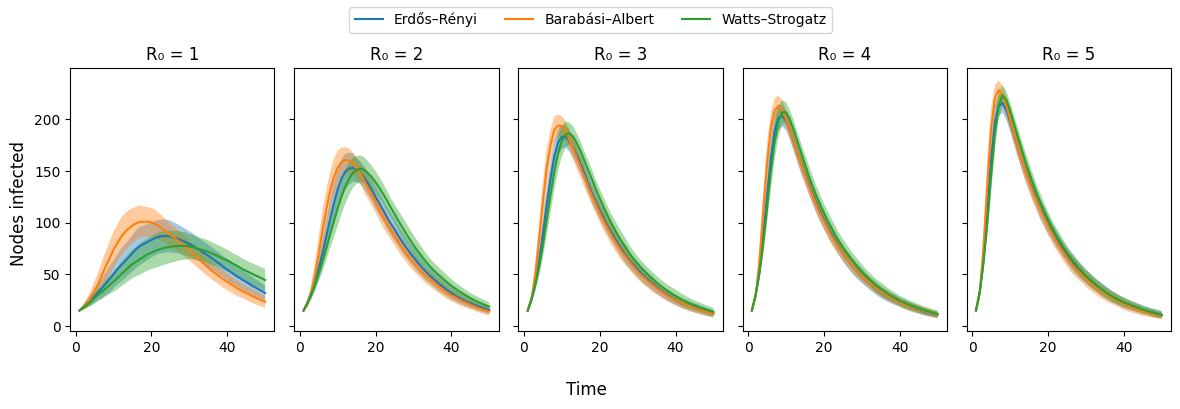

In [ ]:
# model parameters
n_timesteps = 50
n_sims = 100

models = ["ER", "BA", "WS"]
labels = ["Erdős–Rényi", "Barabási–Albert", "Watts–Strogatz"]

# Determine disease parameters
R0 = np.linspace(1, 5, 5)
gamma = 1/14
betas = R0 * gamma

# Determine network parameters
N = 300
k = 4
rewiring_prob = 0.5

fig, axs = plt.subplots(1, len(R0), figsize=(12,4), sharex=True, sharey=True)
for i, beta in enumerate(betas):
    # To store handles for legend
    handles = []
    for model in models:
        
        all_I = []
        for _ in range(n_sims):
            # Create a new graph
            G = make_graph(model, N, k, rewiring_prob, rng)
            # Run simulation
            sim = network_sir(G, beta, gamma, n_timesteps, rng)

            # Get data
            I = []
            for iteration in sim:
                node_count = iteration['node_count']
                I.append(node_count.get(1, 0))
            
            all_I.append(I)

        # Get mean and std
        mean_rand, std_rand = np.array(all_I).mean(axis=0), np.array(all_I).std(axis=0)

        # Plot data
        t = np.arange(1, 1+len(mean_rand))
        h = axs[i].plot(t, mean_rand, label=model)
        axs[i].fill_between(t, mean_rand+std_rand, mean_rand-std_rand, alpha=0.4)
        axs[i].set_title(f'R\u2080 = {int(R0[i])}')
        
        handles.append(h[0])

fig.legend(handles[:3], labels, ncol=3, loc='upper center')
fig.supxlabel('Time')
fig.supylabel('Nodes infected')
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.savefig('spread_network.png', dpi=300)
plt.show()